In [1]:
%matplotlib inline

In [2]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install hmmlearn

from hmmlearn import hmm

In [3]:
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.stats import *
import os
import math
from IPython.display import HTML
from IPython.display import Video

from scipy.signal import deconvolve


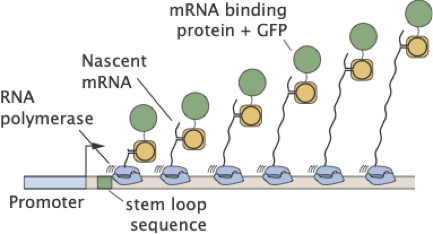

In [540]:
bursts = pd.read_csv('data/Berrocal_particles_analysis.csv')
bursts = bursts[['nucleus_id', 'particle_id', 'set_id', 'ap_raw', 'ap_registered',
       'xPos', 'yPos', 'stripe_id', 'inf_flag', 'time', 'fluo']]

bursts.to_csv('data/Berrocal_particles_analysis.csv',index=False)

In [36]:
Video("2017-12-26-A140P_eve_30uW_550V_composite.mp4")

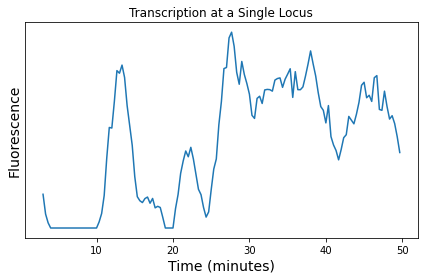

In [38]:
df = bursts[bursts.particle_id == 1.0163]
plt.plot(df.time/60,df.fluo_nonan)
plt.yticks([])
plt.xlabel("Time (minutes)",fontsize=14)
plt.ylabel("Fluorescence",fontsize=14)
plt.title("Transcription at a Single Locus")
plt.tight_layout()

## Transcription occurs in bursts

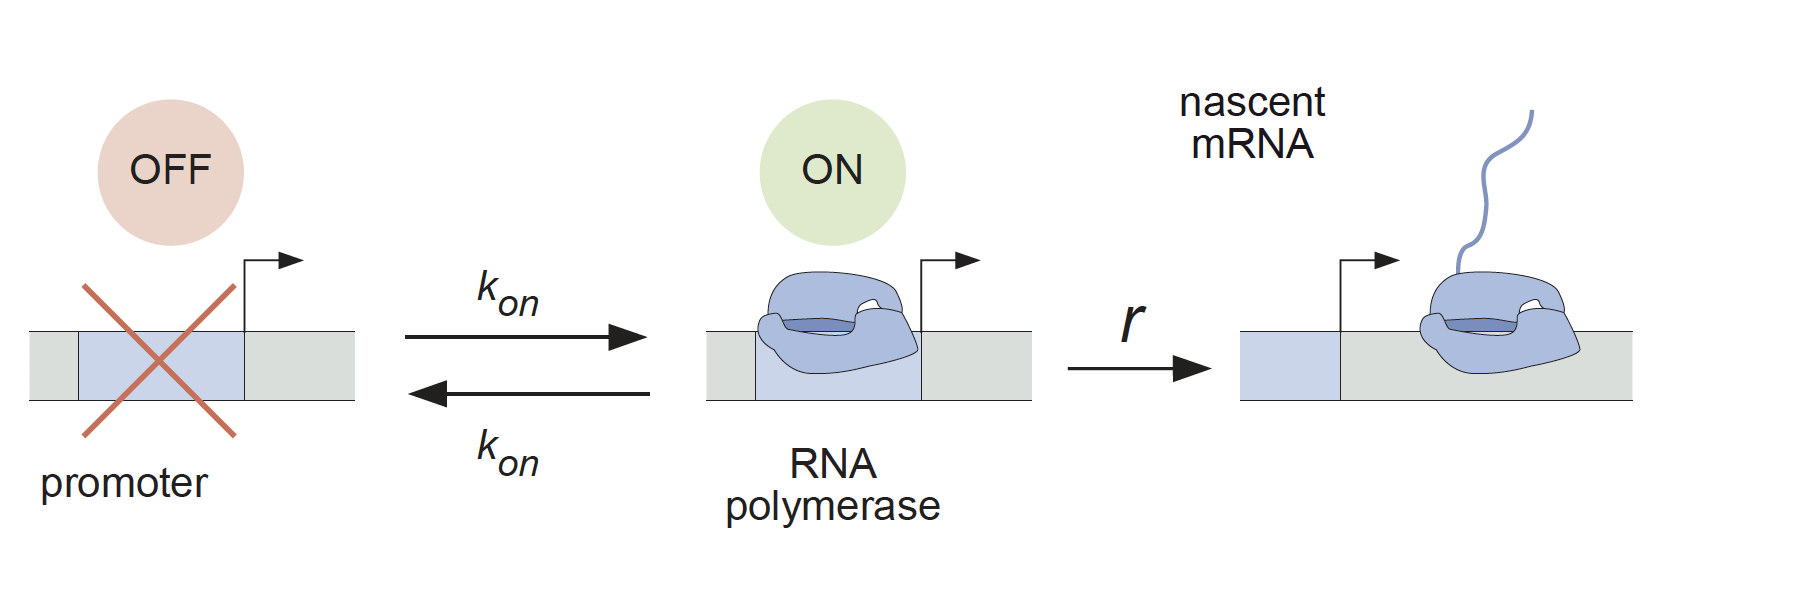

## Today we are going to develop a model of transcriptional bursting

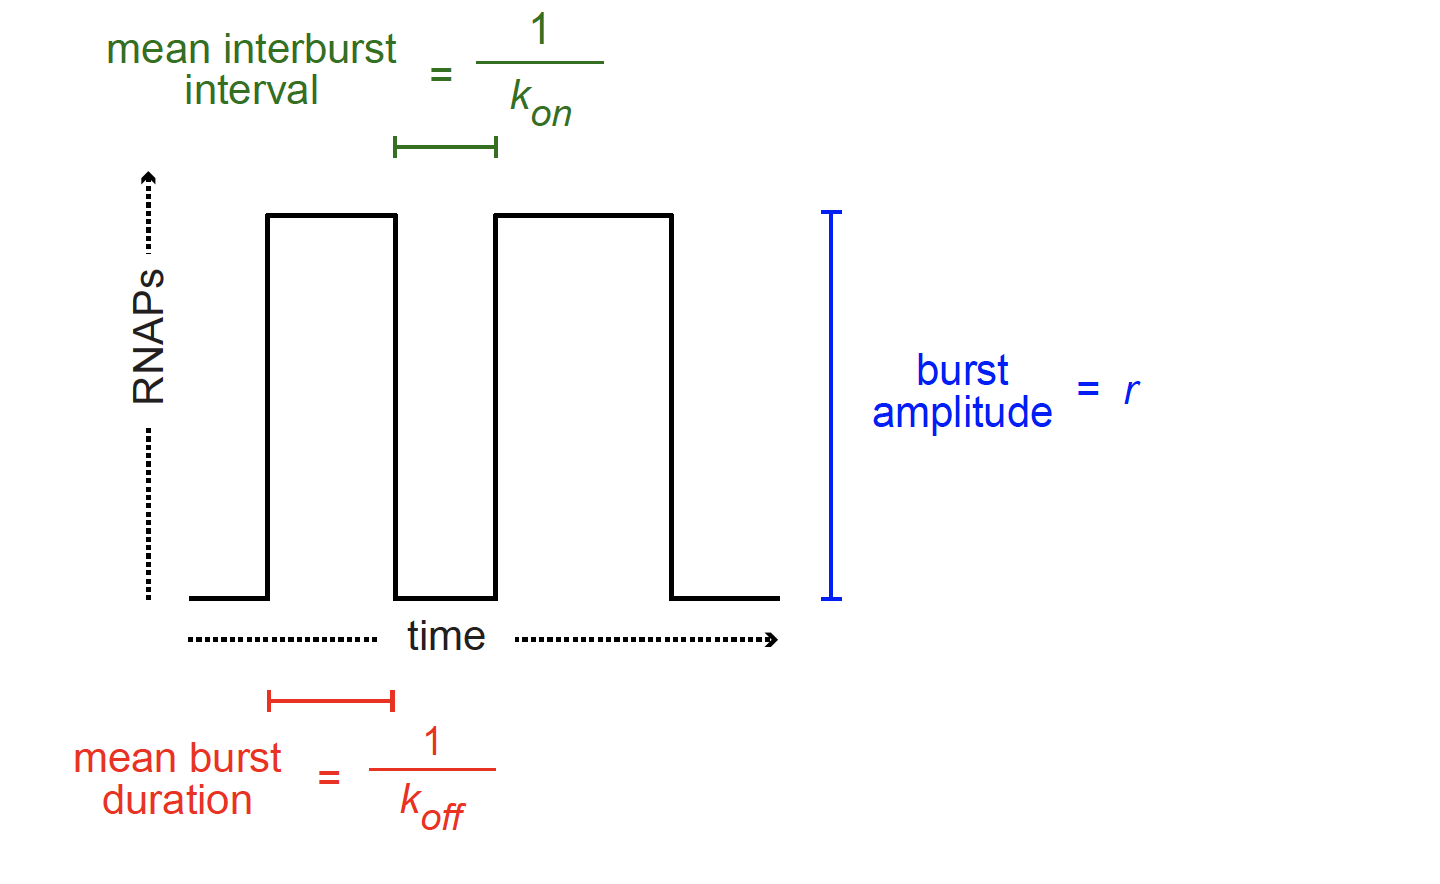

First, let's develop a little intuition about this kind of kinetics.  

We have a process that startd in an OFF state, and has a fixed probability of turning ON. This probability is usually expressed in terms of an "on rate" and written $k_{on}$.  

Let's say we start OFF and monitor its state every second, with the probability being .10 that it will turn on in any giving one second window, which we can express as = .1/sec, meaning we have a $k_{on}$ of .10/sec.

We can write a little simulation of this as follows:

In [469]:

kon = .1

time = 1

while (np.random.rand() > kon):
    time += 1
    
print (time)

14


In [473]:
# time interval

interval = 1

kon = .05

# do a large number of trials to see how long it takes to turn on

time_to_on = []

for trial in range(0,100000):
    
    time = 1
    
    while (np.random.rand() > kon):
        time += interval
        
    time_to_on.append(time)


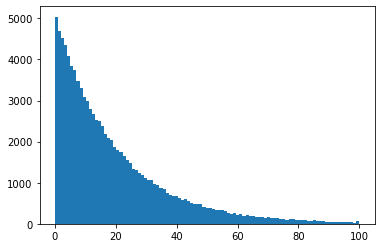

In [474]:
h = plt.hist(time_to_on,bins=np.linspace(0,100,100))

In [475]:
np.mean(time_to_on)

19.97382

In [480]:
# time interval

interval = 1

kon = .05

# do a large number of trials to see how long it takes to turn on

time_to_on = []

for trial in range(0,100000):
    time = 1
    
    while (np.random.rand() > kon):
        time += interval
        
    time_to_on.append(time)


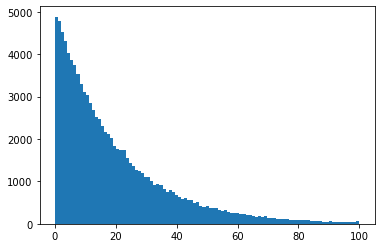

In [481]:
h = plt.hist(time_to_on,bins=np.linspace(0,100,100))

In [484]:
len(time_to_on)

100000

In [487]:
len([x for x in time_to_on if x < 20])

62248

In [478]:
np.mean(time_to_on)

19.97043

In [488]:

interval = 1

for kon in [.01,.05,.1,.25]:

    time_to_on = []

    for trial in range(0,10000):
        time = 1
    
        while (np.random.rand() > kon):
            time += interval
        
        time_to_on.append(time)
    
    print (kon, "\t", np.mean(time_to_on))


0.01 	 99.2224
0.05 	 19.7831
0.1 	 10.046
0.25 	 4.0124


So, now let's think about this mathematically. Let's say we have an entire population of genes in the OFF state, and that each one has a chance of switching to the ON state of $k_{on}$.  

$\large {{dN_{\small OFF}\over{dt}}=-k_{\normalsize on}N_{\small OFF}}$

which is easily solved as the classical equation for exponential decay

$\large {N_{\small OFF} = N_{0}}e^{-k_{on}t}$

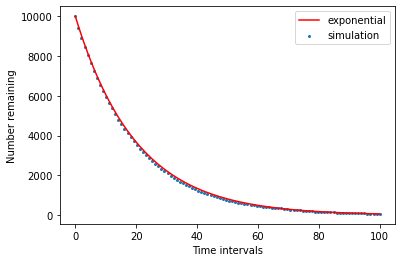

In [489]:
# time interval

interval = 1
kon = .05

number_left = np.zeros(100)

trials = 10000

for trial in range(0,trials):
    time = 0
    number_left[time] += 1
    
    for time in range(1,100):
        if np.random.rand() > kon:
            number_left[time] += 1
        else:
            break

t = np.linspace(0,100,100)
h = plt.scatter(t,number_left,s=4,label='simulation')
plt.plot(t,trials*np.exp(-kon*t),c='red',label='exponential')
plt.xlabel("Time intervals")
plt.ylabel("Number remaining")
plt.legend()

In [493]:
expon.rvs(loc=0,scale=1/20,size=10)

array([0.02798482, 0.07460078, 0.09355319, 0.03716586, 0.01284203,
       0.01356741, 0.07122669, 0.02013402, 0.08312691, 0.01799025])

In [494]:
interval = 1
kon = .05
trials = 100000

In [495]:
on_intervals = expon.rvs(loc=0,scale=1/kon,size=trials)

(array([4856., 4611., 4450., 4376., 4035., 3835., 3505., 3407., 3196.,
        3149., 2984., 2824., 2742., 2537., 2404., 2285., 2172., 2136.,
        1930., 1858., 1787., 1745., 1606., 1490., 1473., 1487., 1283.,
        1321., 1271., 1141., 1042., 1002., 1013.,  964.,  859.,  852.,
         794.,  771.,  699.,  694.,  643.,  584.,  583.,  556.,  591.,
         478.,  464.,  434.,  447.,  451.,  386.,  392.,  378.,  354.,
         332.,  318.,  322.,  296.,  275.,  249.,  237.,  227.,  215.,
         213.,  177.,  191.,  169.,  169.,  172.,  154.,  158.,  140.,
         149.,  118.,  107.,  116.,  113.,  109.,   95.,   84.,   94.,
          77.,   89.,   81.,   77.,   47.,   87.,   57.,   63.,   67.,
          54.,   55.,   37.,   46.,   38.,   28.,   44.,   51.,   31.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 4

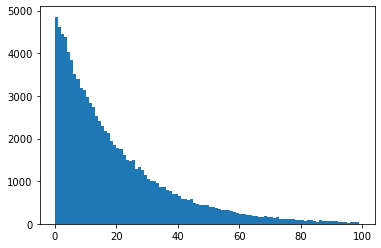

In [496]:
plt.hist(on_intervals,bins=np.arange(0,100))

In [499]:
h = np.histogram(on_intervals,bins=np.arange(0,100))

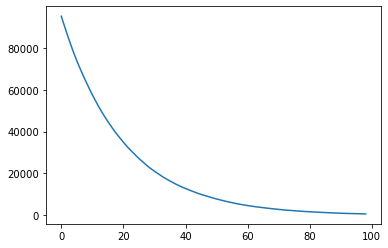

In [502]:
plt.plot(trials - np.cumsum(h[0]))


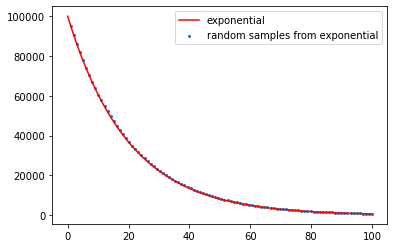

In [503]:
# can also sample random values from exponential 

# time interval

interval = 1
kon = .05
trials = 100000

on_intervals = expon.rvs(loc=0,scale=1/kon,size=trials)
h = np.histogram(on_intervals,bins=np.arange(0,100))
t = np.linspace(1,100,99)
plt.scatter(t,trials - np.cumsum(h[0]),label='random samples from exponential',s=4)
t = np.linspace(0,100,100)
plt.plot(t,trials*np.exp(-kon*t),c='red',label='exponential')
plt.legend()

Now, let's consider two ways to simulate this process of a gene turning on and off. 

First, just create a discrete model where we go back and forth between state 0 (OFF) and state 1 (ON) with probabilities $k_{on}$ and $k_{off}$.  

In [506]:
a = [1,2,3,4,5,6]

a[-1]

6

([<matplotlib.axis.YTick at 0x7fe421fb6320>,
 [Text(0, 0, 'OFF'), Text(0, 1, 'ON')])

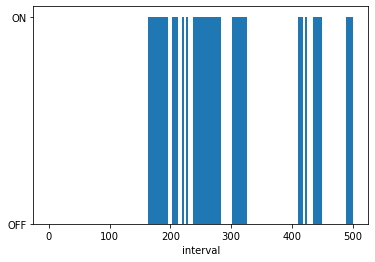

In [510]:
kon  = 1 / 30
koff = 1 / 30
total_time = 500

s = [0]

time = 0

while time < total_time:
    
    if s[-1] == 0:
        if np.random.rand() <= kon:
            s.append(1)
        else:
            s.append(0)
            
    else:
        if np.random.rand() <= koff:
            s.append(0)
        else:
            s.append(1)
            
    time += 1
    
plt.bar(np.arange(0,len(s)),s,1)
plt.xlabel("interval")
plt.yticks([0,1],['OFF','ON'])

In [512]:
float(expon.rvs(loc=0,scale=1/kon,size=1))

19.275750786669203

In [513]:
float(expon.rvs(loc=0,scale=1/koff,size=1))

123.39986619139998

In [514]:
float(expon.rvs(loc=0,scale=1/kon,size=1))

2.6892022522468593

In [515]:
float(expon.rvs(loc=0,scale=1/koff,size=1))

42.320513924976254

In [517]:
kon  = 1 / 10
koff = 1 / 20
total_time = 1000

s = [0]

t = 0
promoter_state = 0
intervals = []

while t < total_time:
    
    if promoter_state == 0:
        
        off_interval = float(expon.rvs(loc=0,scale=1/kon,size=1))
        t += off_interval
        promoter_state = 1
        
        print ("0 --> 1", t)
        
    else:
        on_interval = float(expon.rvs(loc=0,scale=1/koff,size=1))
        
        t += on_interval
        promoter_state = 0
        print ("1 --> 0", t)




0 --> 1 27.43130339464555
1 --> 0 65.39786165415555
0 --> 1 84.70194802891271
1 --> 0 93.238916894905
0 --> 1 98.73391519937951
1 --> 0 99.77142123603794
0 --> 1 104.99921266046101
1 --> 0 108.87223238676235
0 --> 1 110.11360833728152
1 --> 0 145.32297169889924
0 --> 1 148.2819831206772
1 --> 0 210.09761040373007
0 --> 1 215.6846901436197
1 --> 0 271.5907860720976
0 --> 1 273.7548596958227
1 --> 0 277.37295285506355
0 --> 1 279.6384615739504
1 --> 0 319.25090584687916
0 --> 1 319.6459368539538
1 --> 0 330.84277404218614
0 --> 1 337.5017535408398
1 --> 0 359.579584171839
0 --> 1 368.90572443321815
1 --> 0 384.85890789898383
0 --> 1 388.8970448738159
1 --> 0 400.61284750303395
0 --> 1 404.86030240158493
1 --> 0 413.6148891822177
0 --> 1 417.9527163038247
1 --> 0 427.15035395198925
0 --> 1 438.0191595152851
1 --> 0 439.39853670515856
0 --> 1 443.84867651216126
1 --> 0 515.8830675303249
0 --> 1 517.9195034969896
1 --> 0 548.2178494343436
0 --> 1 561.8032269506327
1 --> 0 573.0844311965064


0 --> 1 35.15836274731363
1 --> 0 40.320532803474734
0 --> 1 83.04313032087825
1 --> 0 90.5346735740643
0 --> 1 105.8134101933203
1 --> 0 181.472591060144
0 --> 1 211.5169734737192
1 --> 0 221.44912899279905
0 --> 1 227.30383751464964
1 --> 0 314.72481995299404
0 --> 1 411.16558034327
1 --> 0 415.6759133211014
0 --> 1 438.83955535481635
1 --> 0 495.2763195242033
0 --> 1 549.1672251103737


([<matplotlib.axis.YTick at 0x7fe42eaa3940>,
 [Text(0, 0, 'OFF'), Text(0, 1, 'ON')])

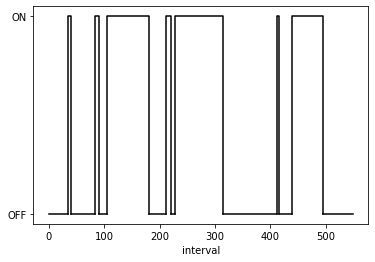

In [525]:
kon  = 1 / 50
koff = 1 / 50
total_time = 500

s = [0]

t = 0
promoter_state = 0
intervals = []

while t < total_time:
    
    if promoter_state == 0:
        
        off_interval = float(expon.rvs(loc=0,scale=1/kon,size=1))
        
        t_start = t
        t_end   = t + off_interval
        intervals.append([t_start,t_end,0])
        plt.plot(np.array([t_start,t_end]),np.array([0,0]),c='black')
        promoter_state = 1
        t = t_end
        print ("0 --> 1", t)
        
    else:
        on_interval = float(expon.rvs(loc=0,scale=1/koff,size=1))
        t_start = t
        t_end = t + on_interval
        intervals.append([t_start,t_end,1])

        plt.plot(np.array([t_start,t_start,t_end,t_end]),np.array([0,1,1,0]),c='black')
        promoter_state = 0
        t = t_end
        print ("1 --> 0", t)

plt.xlabel("interval")
plt.yticks([0,1],['OFF','ON'])

In [526]:
kon  = 1 / 20
koff = 1 / 30
total_time = 10000

s = [0]

t = 0

state_sequence = np.zeros(total_time + 1)
promoter_state == 0
intervals = []

while t < total_time:
    
    if promoter_state == 0:
        off_interval = float(expon.rvs(loc=0,scale=1/kon,size=1))
        t_start = t
        t_end   = t + off_interval

        intervals.append([t_start,t_end,0])
        promoter_state = 1
        t = t_end
        
    else:
        on_interval = float(expon.rvs(loc=0,scale=1/koff,size=1))
        t_start = t
        t_end = t + on_interval
        
        t_end   = min(t_end,total_time)
        
        tsm = math.modf(t_start)
        tem = math.modf(t_end)
        
        if tem[1] > tsm[1]:
            state_sequence[int(tsm[1])] += 1.0 - tsm[0]
            for i in range(int(t_start+1),int(t_end)):
                state_sequence[i] += 1
            state_sequence[int(tem[1])] += tem[0]
        else:
            state_sequence[int(tsm[1])] += t_end - t_start

            
        intervals.append([t_start,t_end,1])
        promoter_state = 0
        t = t_end
        
intervals = pd.DataFrame(data=intervals,columns=['Start','End','State'])


<BarContainer object of 750 artists>

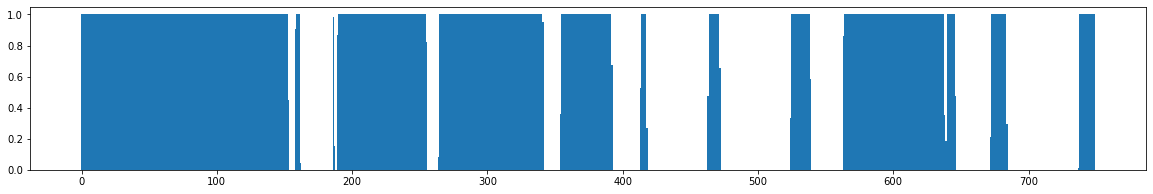

In [528]:
s = 0
e = 750

plt.figure(figsize=(20,3))

d = state_sequence[s:e]

plt.bar(np.arange(s,e),d,1)

## There's one more piece to the puzzle

When the gene is ON it is making RNA. RNA is made by RNA polymerase, which is a big molecule that gets loaded on at a fixed rate $r$ and then takes a roughly fixed amount of time to traverse the gene. Once loaded, polymerases continue on the gene for a roughly fixed duration $D$. We can approximate this by convolving our function with a pulse of width $D$ and height $r$ and the resulting function becomes a measure of the number of polymerases on the gene as a function of time.

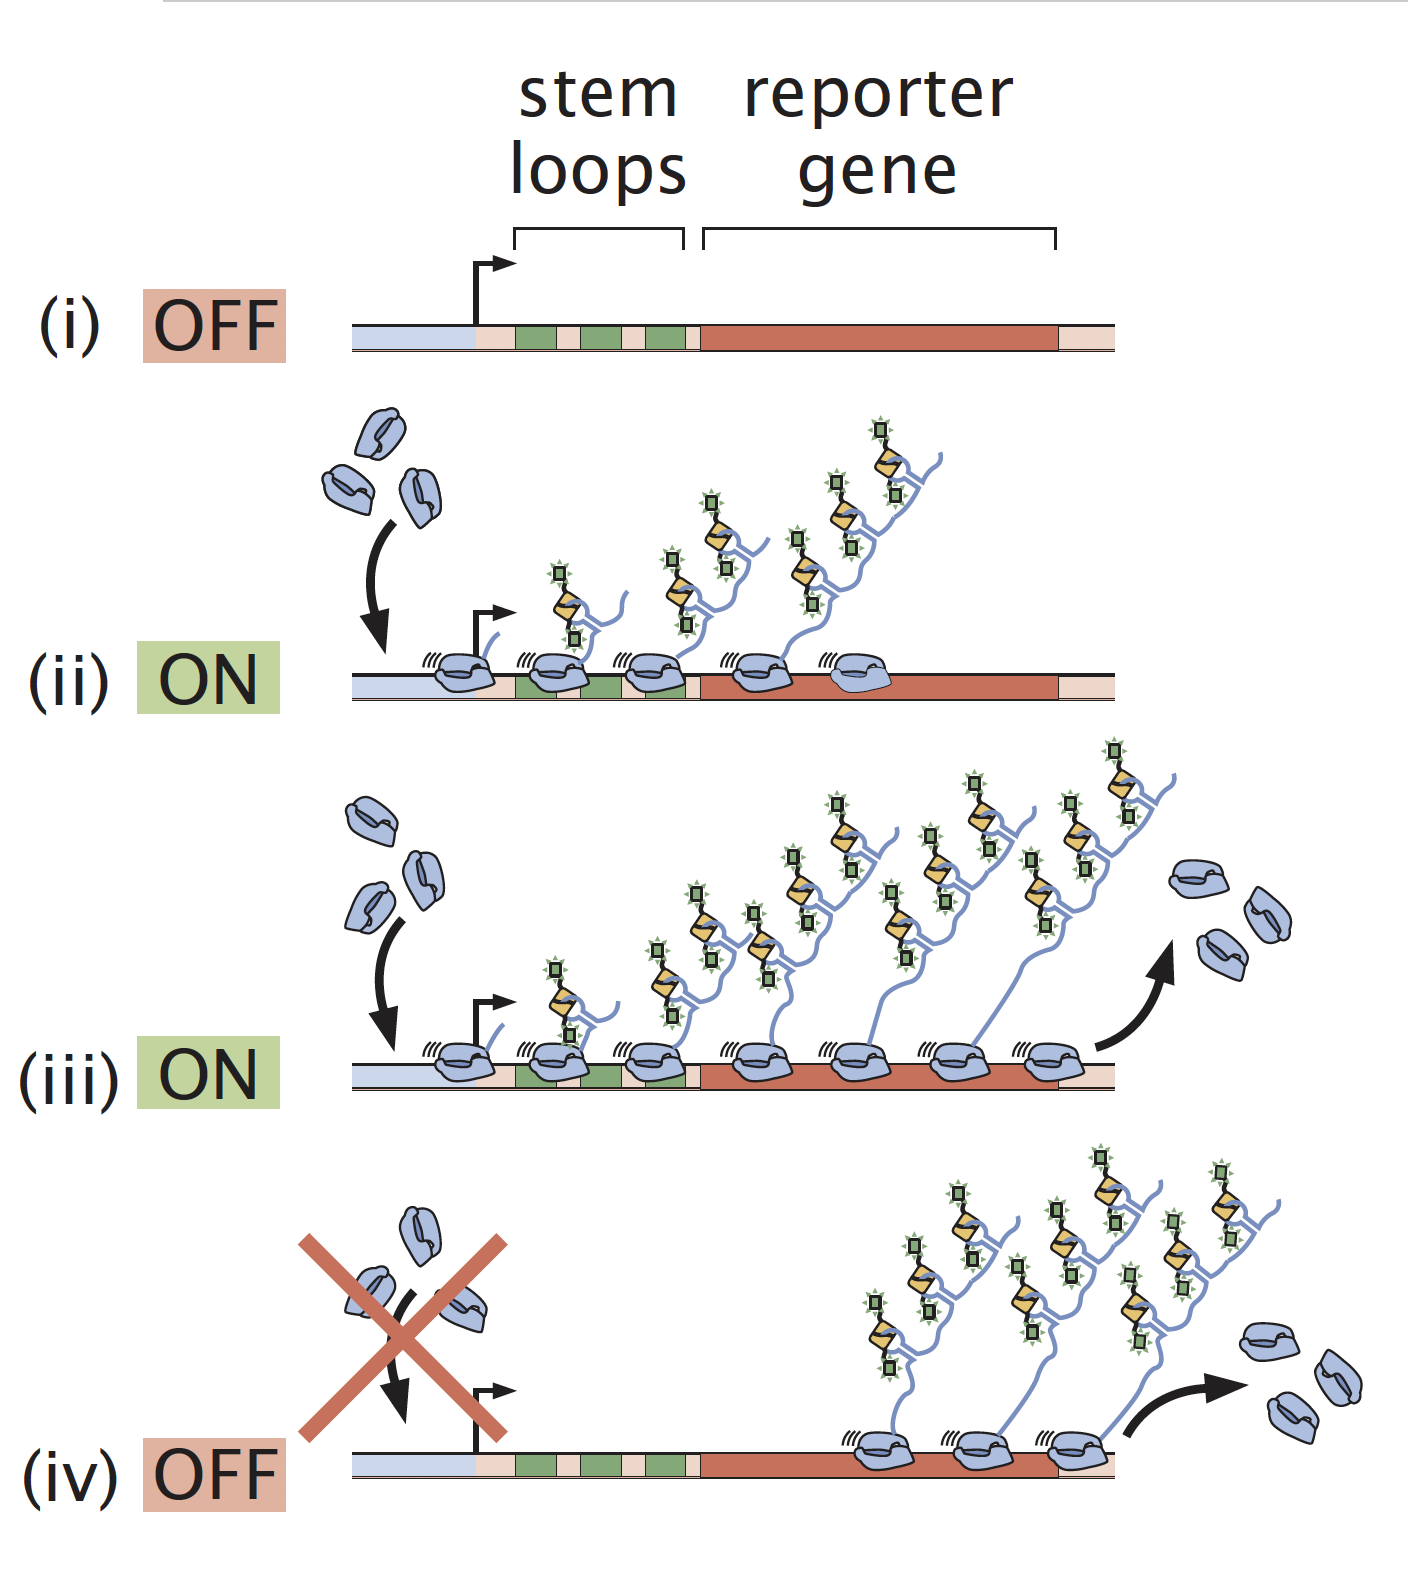

In [529]:
s = [0] * 25 + [1] * 10 + [0] * 50

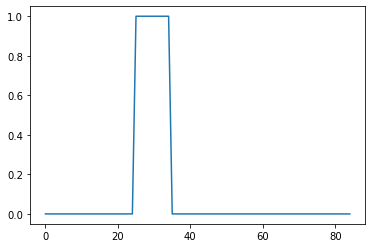

In [530]:
plt.plot(s)

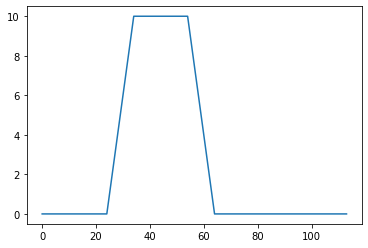

In [534]:
plt.plot(np.convolve(np.array(s),np.ones(30)))

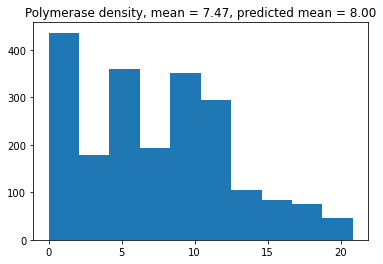

In [535]:
mean_on_time = 30
koff = 1 / mean_on_time

mean_off_time = 60
kon = 1 / mean_off_time

loading_rate = .2
signal_duration = 120

total_time = 2000

t = 0

state_sequence = np.zeros(total_time + 1)
promoter_state == 0
intervals = []

while t < total_time:
    
    if promoter_state == 0:
        off_interval = float(expon.rvs(loc=0,scale=1/kon,size=1))
        t_start = t
        t_end   = t + off_interval

        intervals.append([t_start,t_end,0])
        promoter_state = 1
        t = t_end
        
    else:
        on_interval = float(expon.rvs(loc=0,scale=1/koff,size=1))
        t_start = t
        t_end = t + on_interval
        t_end   = min(t_end,total_time)
        
        tsm = math.modf(t_start)
        tem = math.modf(t_end)
        
        if tem[1] > tsm[1]:
            state_sequence[int(tsm[1])] += 1.0 - tsm[0]
            for i in range(int(t_start+1),int(t_end)):
                state_sequence[i] += 1
            state_sequence[int(tem[1])] += tem[0]
        else:
            state_sequence[int(tsm[1])] += t_end - t_start

        intervals.append([t_start,t_end,1])
        promoter_state = 0
        t = t_end
        
intervals = pd.DataFrame(data=intervals,columns=['Start','End','State'])
polymerase_density = np.convolve(state_sequence,loading_rate * np.ones(signal_duration))

h = plt.hist(polymerase_density)

cycle_time = mean_on_time + mean_off_time
pred_mean_density = loading_rate * signal_duration * mean_on_time / cycle_time
t = plt.title("Polymerase density, mean = %.2f, predicted mean = %.2f" % (np.mean(polymerase_density),pred_mean_density))

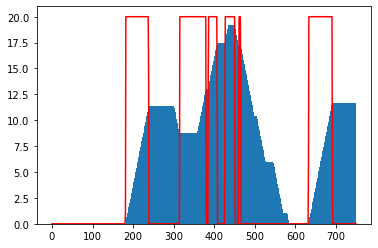

In [538]:
s = 0
e = 750

d = polymerase_density[s:e]

plt.bar(np.arange(s,e),d,1)
plt.plot(20*state_sequence[s:e],c='red')

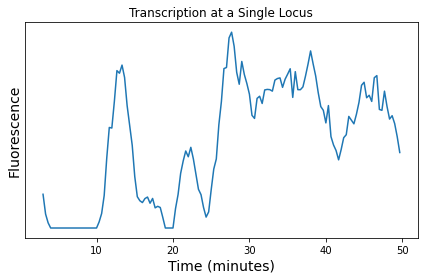

In [542]:
df = bursts[bursts.particle_id == 1.0163]
plt.plot(df.time/60,df.fluo)
plt.yticks([])
plt.xlabel("Time (minutes)",fontsize=14)
plt.ylabel("Fluorescence",fontsize=14)
plt.title("Transcription at a Single Locus")
plt.tight_layout()

In [553]:
dc = deconvolve(polymerase_density,np.ones(signal_duration))

<BarContainer object of 750 artists>

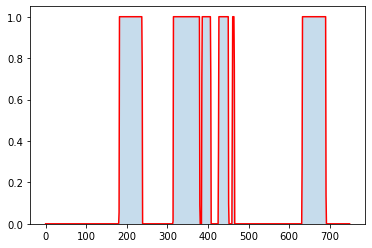

In [554]:
s = 0
e = 750

d = dc[0][s:e] / loading_rate
plt.plot(np.arange(s,e),d,1,c='red')

d = state_sequence[s:e]
plt.bar(np.arange(s,e),d,1,alpha=.25)

Real data aren't that perfect though. They have noise. So let's add some.

In [555]:
polymerase_density_noise = polymerase_density + norm.rvs(loc=0,scale=.5,size=len(polymerase_density))

<BarContainer object of 750 artists>

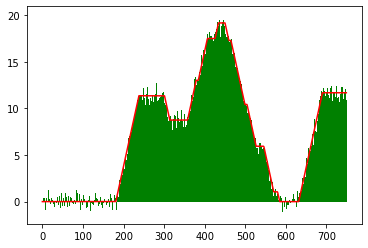

In [562]:
s = 0
e = 750

d = polymerase_density[s:e] 
plt.plot(np.arange(s,e),d,1,c='red')

d = polymerase_density_noise[s:e]
plt.bar(np.arange(s,e),d,1,alpha=1,color='green')

In [563]:
dc = deconvolve(polymerase_density_noise,np.ones(signal_duration))

<BarContainer object of 750 artists>

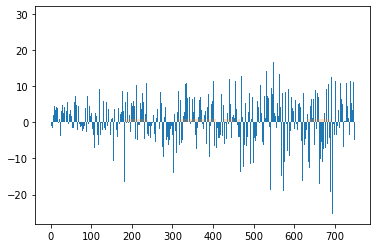

In [564]:
s = 0
e = 750

d = dc[0][s:e] / loading_rate
plt.bar(np.arange(s,e),d,1)

d = state_sequence[s:e]
plt.bar(np.arange(s,e),d,1,alpha=.25)

## YIKES!!! What went wrong?

In [102]:
polymerase_density_noise = polymerase_density + norm.rvs(loc=0,scale=.25,size=len(polymerase_density))

In [565]:
basis = np.zeros((len(polymerase_density_noise),len(polymerase_density_noise)))

for i in range(0,len(polymerase_density_noise)):
    np.put(basis[i],np.arange(i,min(i+signal_duration,len(polymerase_density_noise))),1)

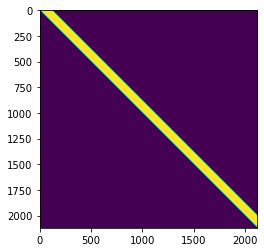

In [566]:
plt.imshow(basis)

In [567]:
polymerase_nnls       = scipy.optimize.nnls(basis.T,polymerase_density)[0] / loading_rate
polymerase_noise_nnls = scipy.optimize.nnls(basis.T,polymerase_density_noise)[0] / loading_rate

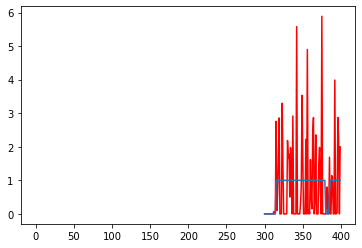

In [570]:
s = 300
e = 400

d = polymerase_noise_nnls[s:e]
plt.plot(np.arange(s,e),d,1,c='red')

d = state_sequence[s:e]
plt.plot(np.arange(s,e),d,1)

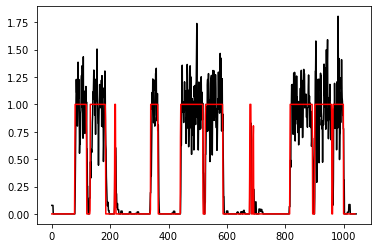

In [170]:
#plt.plot(polymerase_noise_nnls[0],c='red')
x = np.convolve(polymerase_noise_nnls,np.ones(5)/5)
plt.plot(x,c='black')

plt.plot(polymerase_nnls,c='red')


In [171]:
mean_on_time = 30
koff = 1 / mean_on_time

mean_off_time = 60
kon = 1 / mean_off_time

In [274]:
ghmm = hmm.GaussianHMM(n_components=2, covariance_type="spherical")
ghmm.startprob_= np.array([1,0])
ghmm.transmat_ = [
    [1-kon,kon],
    [koff,1-koff]
]
ghmm.means_ = np.array([[0], [1]])
ghmm.covars_ = np.array([.1,.1])
ghmm.init_params = ''

In [275]:
hmm_in = np.array([[x] for x in polymerase_nnls])
hmm_out = ghmm.decode(hmm_in)

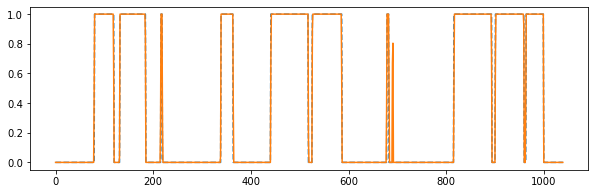

In [276]:
plt.figure(figsize=(10,3))
plt.plot(hmm_out[1],linestyle='dashed')
plt.plot(polymerase_nnls)

In [277]:
hmm_in = np.array([[x] for x in polymerase_noise_nnls])
hmm_out_noise = ghmm.decode(hmm_in)

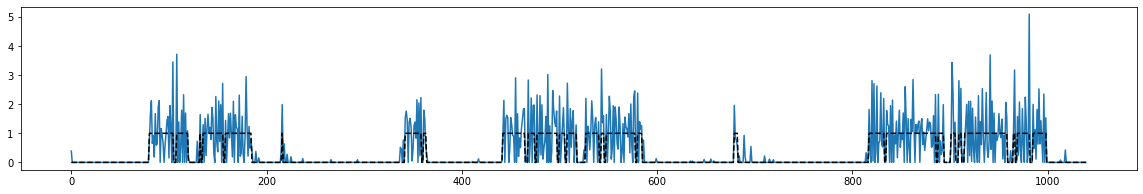

In [278]:
plt.figure(figsize=(20,3))
plt.plot(polymerase_noise_nnls)
plt.plot(hmm_out_noise[1],linestyle='dashed',color='black')


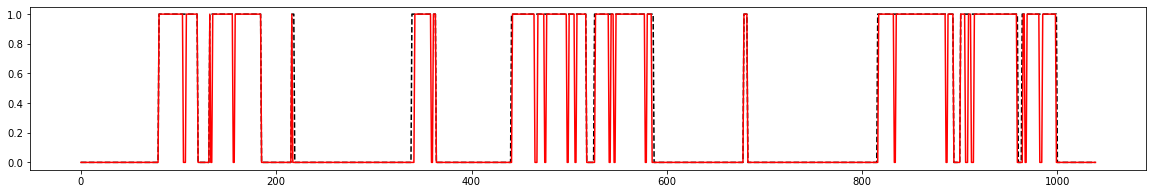

In [279]:
plt.figure(figsize=(20,3))
plt.plot(hmm_out[1],linestyle='dashed',color='black')
plt.plot(hmm_out_noise[1],color='red')

(array([988.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  52.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

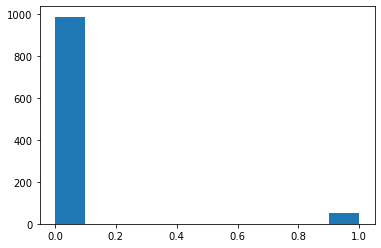

In [280]:
plt.hist(hmm_out[1] - hmm_out_noise[1])

In [389]:
hmm_in = np.array([[x] for x in polymerase_nnls])
train_x = np.concatenate([hmm_in,hmm_in])
train_l = [len(hmm_in),len(hmm_in)]

In [396]:
gf = hmm.GaussianHMM(n_components=2, covariance_type="spherical")
gf.startprob_= np.array([1,0])
gf.transmat_ = [
    [1-kon,kon],
    [koff,1-koff]
]
gf.means_ = np.array([[0], [1]])
gf.covars_ = np.array([.1,.1])
gf.init_params = 'stmc'
gf.init_params = ''
gf.verbose = True

In [402]:
gf1 = gf.fit(train_x,train_l)

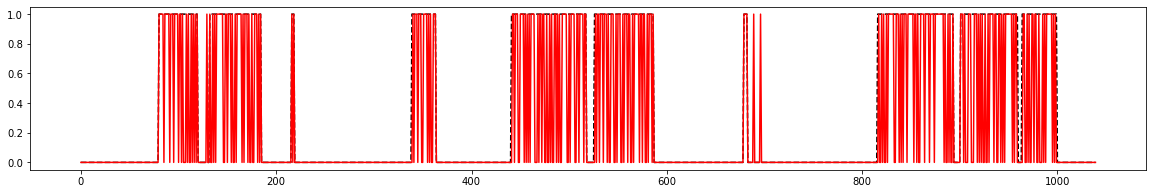

In [406]:
hmm_in = np.array([[x] for x in polymerase_noise_nnls])
hmm_out_noise = gf.predict(hmm_in)
plt.figure(figsize=(20,3))
plt.plot(hmm_out[1],linestyle='dashed',color='black')
plt.plot(hmm_out_noise,color='red')

In [408]:
gf.get_stationary_distribution()

array([0.57940311, 0.42059689])

In [409]:
gf1.get_stationary_distribution()

array([0.57940311, 0.42059689])

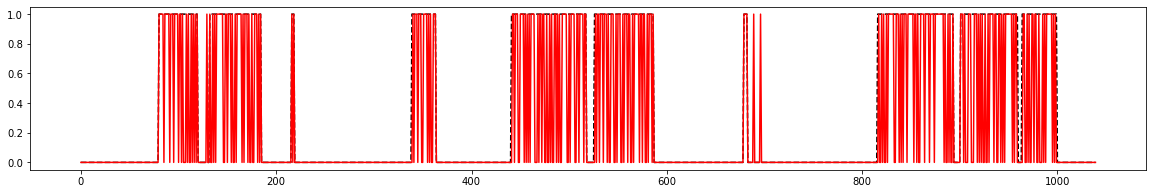

In [393]:
hmm_in = np.array([[x] for x in polymerase_noise_nnls])
hmm_out_noise = gf1.predict(hmm_in)
plt.figure(figsize=(20,3))
plt.plot(hmm_out[1],linestyle='dashed',color='black')
plt.plot(hmm_out_noise,color='red')